# Classifier to classify fake reviews and real reviews. <br>
**Files Used**<br>
Fake Reviews: data/complete_fake_reviews.pkl <br>
Real Reviews: data/complete_real_reviews.pkl <br>
**For Pre-trained Models** <br>
Tokenizer: tokenizers/tokenizer_classifer.pkl <br>
Model Weights: model_weights/classifier.keras



In [ ]:
#mounting the drive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

drive.mount('/content/drive')

In [2]:
#importing the libraries
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import pickle
import random
from random import choice
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve,precision_score
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot


Using TensorFlow backend.


In [ ]:
import nltk
nltk.download("punkt")
nltk.download("stopwords")


In [3]:
from IPython.display import HTML, display

def set_css():
  """ A function for wrapping text displayed in the output """
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
  
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
#defining the constants
VOCAB_SIZE = 100000
INPUT_LEN = 150

# Loading the data

In [ ]:
with open("data/complete_fake_reviews.pkl", "rb") as f:
  fake_reviews_list = pickle.load(f)

In [ ]:
with open("data/complete_real_reviews.pkl", "rb") as f:
  real_reviews_list = pickle.load(f)
real_reviews_list = real_reviews_list[:len(fake_reviews_list)]

In [ ]:
#cleaning the fake reviews text when using VAE_50K.txt file. Has the tokens <GO>,"\n"
for counter in range(len(real_reviews_list)):
  real_reviews_list[counter] = real_reviews_list[counter].replace("\n","")

In [ ]:
print("Number of real reviews: ", len(real_reviews_list))
print("Number of fake reviews: ",len(fake_reviews_list))

In [ ]:
#creating the complete reviews list

reviews_list = fake_reviews_list.copy()
reviews_list.extend(real_reviews_list)

print("Total number of reviews: ", len(reviews_list))

In [ ]:
#preparing the labels
labels = [0]*len(fake_reviews_list)
labels.extend([1]*len(real_reviews_list))

# Data Pre-processing

In [10]:
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
import re
stop_words = set(stopwords.words('english'))

In [6]:
def clean_text(reviews_list :list) -> list:
  """
  A function to pre-process text.

  This function removes the punctuation marks, numbers and stopwords from the text. It converts the text
  to lower case. It also removes reviews with less than 10 words.
  Args:
    reviews_list: A list of reviews
  Returns: 
    A list of lists where each list corresponds to the words in the corresponding review.

  """
  cleaned_reviews = []
  for line in reviews_list:
    
    line = re.sub("\W", " ", line)
    #tokenize the sentences into words
    tokens = word_tokenize(line)
    
    words  = [word.lower() for word in tokens if word.isalpha()]
    
    words = [word for word in words if word not in stop_words]
    cleaned_reviews.append(words)


  return cleaned_reviews


In [12]:
#test case
sample = "The food was great!! But no AC..delicious....i"
sample_cleaned = clean_text([sample])
print(sample_tokenized)

[['food', 'great', 'ac', 'delicious']]


In [ ]:
#cleaning the text
cleaned_review = clean_text(reviews_list)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cleaned_review, labels, test_size = 0.1, random_state = 100, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 100, shuffle=True)
print("Size of training set: ", len(X_train))
print("Size of validation set: ", len(X_val))
print("Size of test set: ", len(X_test))

In [ ]:
#converting to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
#details about the data
y_train_zeroes = np.where(y_train==0)
print("Number of fake reviews in y_train = ", len(y_train_zeroes[0]))
y_val_zeroes = np.where(y_val==0)
print("Number of fake reviews in y_val = ", len(y_val_zeroes[0]))
y_test_zeroes = np.where(y_test==0)
print("Number of fake reviews in y_test = ", len(y_test_zeroes[0]))

In [ ]:
import collections
#finding the average number of words in a review in the training set
total_num = 0
lengths_dict = collections.defaultdict(int)

for review in X_train:
  total_num+=len(review)
  lengths_dict[len(review)]+=1

avg_word_nos = total_num//len(X_train)
print("Average number of words in a review: ",avg_word_nos)

#checking if the average number of words is in the range of the INPUT_LEN
if (avg_word_nos > (INPUT_LEN+20)) or (avg_word_nos < (INPUT_LEN-20)):
  print("Please update your INPUT_LEN variable.")

If training a new model from scratch, create a new tokenizer. <br>
If reusing the pre-trained model, then please load the tokenizer from the file

In [ ]:
#defining the tokenizer
tokenizer  = tf.keras.preprocessing.text.Tokenizer(num_words = VOCAB_SIZE,lower = True, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [20]:
with open("tokenizers/tokenizer_classifier.pkl", "rb+") as f:
  tokenizer = pickle.load(f)

In [ ]:
#tokenization and padding
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq = np.array(pad_sequences(X_train_seq, INPUT_LEN, padding="pre",truncating="post"))

In [ ]:
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_seq = np.array(pad_sequences(X_val_seq, INPUT_LEN, padding="pre",truncating="post"))


In [ ]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq = np.array(pad_sequences(X_test_seq, INPUT_LEN, padding="pre",truncating="post"))

# Building the classifier

In [17]:
# load the whole embedding into memory
embeddings_index = dict()
#path to the GloVE 300-dimensional embedding file
#download the embeddings from https://nlp.stanford.edu/projects/glove/

f = open('glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [21]:
#creating the embedding matrix for the whole vocabulary
num_words = len(tokenizer.word_index)+1
print("Total number words in the vocabulary: ", num_words)

Total number words in the vocabulary:  82092


In [ ]:
# create a weight matrix for words in training set
embedding_matrix = np.zeros((num_words, 300))

for word, i in tokenizer.word_index.items():
  
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i<num_words:
        embedding_matrix[i] = embedding_vector

In [ ]:
tf.keras.backend.clear_session()

In [24]:
#hyperparameters
num_of_filters = 64
kernel_size = 4

classifier_model=tf.keras.models.Sequential()
#embedding layer
classifier_model.add(layers.Embedding(num_words,300,weights=[embedding_matrix], input_length=INPUT_LEN,trainable=False)) 

#CNN layer
classifier_model.add(layers.Conv1D(filters=num_of_filters, kernel_size=kernel_size,activation='relu'))
classifier_model.add(layers.MaxPool1D(pool_size=2))
classifier_model.add(layers.BatchNormalization())

#LSTM
classifier_model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))
classifier_model.add(layers.Dropout(0.5))

classifier_model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False)))
classifier_model.add(layers.Dropout(0.25))

#Dense layer
classifier_model.add(layers.Dense(128, activation='relu'))
classifier_model.add(layers.Dropout(0.25))
#classifier_model.add(layers.Dense(64, activation='relu'))
classifier_model.add(layers.Dense(32, activation='relu'))
classifier_model.add(layers.Dense(2, activation='softmax'))

classifier_model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          24627600  
_________________________________________________________________
conv1d (Conv1D)              (None, 147, 64)           76864     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 73, 64)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 64)            256       
_________________________________________________________________
bidirectional (Bidirectional (None, 73, 512)           657408    
_________________________________________________________________
dropout (Dropout)            (None, 73, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               6

In [ ]:
#loading the model weights
classifier_model.load_weights("model_weights/classifier.keras")
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015),
             loss='categorical_crossentropy',
            metrics=['accuracy'])


In [ ]:
# Load the extension and start TensorBoard

%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
#converting to one hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [ ]:
from keras.callbacks import TensorBoard
from time import time
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))


In [ ]:
history = classifier_model.fit(X_train_seq, y_train_one_hot,
                    epochs=5,
                    verbose=1,
                    batch_size = 256,
                    validation_data=(X_val_seq, y_val_one_hot),
                    callbacks=[tensorboard]
              )


In [ ]:
#saving the model weights
classifier_model.save_weights("model_weights/classifier_2.keras")

# Model Evaluation

In [ ]:
#getting the prediction classes for the training set
train_predictions = classifier_model.predict_classes(X_train_seq)

#confusion matrix for the training set
conf_mat_train = confusion_matrix(y_train, train_predictions)

print("Confusion Matrix: \n",conf_mat_train )

#printing the accuracy on the training set
loss,accuracy = classifier_model.evaluate(X_train_seq, y_train_one_hot)
print("Accuracy on the training set: ", accuracy)

Confusion Matrix: 
 [[131392   5321]
 [  1935 128182]]
8339/8339 [==============================] - 99s 12ms/step - loss: 0.0800 - accuracy: 0.9728
Accuracy on the training set:  0.9728066325187683


In [ ]:
#getting the prediction classes for the validation set
val_predictions = classifier_model.predict_classes(X_val_seq)

#confusion matrix for the training set
conf_mat_val = confusion_matrix(y_val, val_predictions)

print("Confusion Matrix: \n",conf_mat_val )

#printing the accuracy on the training set
loss,accuracy = classifier_model.evaluate(X_val_seq, y_val_one_hot)
print("Accuracy on the validation set: ", accuracy)

Confusion Matrix: 
 [[14688   574]
 [  213 14173]]
927/927 [==============================] - 11s 12ms/step - loss: 0.0792 - accuracy: 0.9735
Accuracy on the validation set:  0.9734551906585693


In [ ]:
#getting the prediction classes for the test set
test_predictions = classifier_model.predict_classes(X_test_seq)

#confusion matrix for the training set
conf_mat_test = confusion_matrix(y_test, test_predictions)

print("Confusion Matrix: \n",conf_mat_test )

#printing the accuracy on the training set
loss,accuracy = classifier_model.evaluate(X_test_seq, y_test_one_hot)
print("Accuracy on the testing set: ", accuracy)

Confusion Matrix: 
 [[15840  1185]
 [  242 15675]]
1030/1030 [==============================] - 12s 12ms/step - loss: 0.1476 - accuracy: 0.9567
Accuracy on the testing set:  0.9566814303398132


### Plotting precision-recall curve

In [ ]:
#getting the actual prediction probabilities on training set and extracting the probability for the 0 class
t_preds = classifier_model.predict(X_train_seq)
t_preds_zeros = t_preds[:, 0]
#t_preds_zeros.shape

In [ ]:
#calculating the precision and recall for the training set
t_precision, t_recall, thresholds = precision_recall_curve(y_train, t_preds_zeros, pos_label=0)

#finding the precision value at a recall of 90% and the threshold
train_ind= 0
for i in range(len(t_precision)):
  if t_precision[i]>=0.9:
    train_ind = i
    break
print("Precision at recall 90%: ", t_precision[train_ind])
print("Threshold: ", thresholds[train_ind])

Precision at recall 90%:  0.9000013275628601
Threshold:  0.030574063


In [ ]:
#getting the actual prediction probabilities on validation set and extracting the probability for the 0 class
v_preds = classifier_model.predict(X_val_seq)
v_preds_zeros = v_preds[:, 0]


In [ ]:
#calculating the precision and recall for the validation set
v_precision, v_recall, v_thresholds = precision_recall_curve(y_val, v_preds_zeros, pos_label=0)

#finding the precision value at a recall of 90% and the threshold
val_ind= 0
for i in range(len(v_precision)):
  if v_precision[i]>=0.9:
    val_ind = i
    break
print("Precision at recall 90%: ", v_precision[val_ind])
print("Threshold: ", v_thresholds[val_ind])

Precision at recall 90%:  0.9000059484861103
Threshold:  0.03005678


In [ ]:
#getting the actual prediction probabilities on test set and extracting the probability for the 0 class
test_preds = classifier_model.predict(X_test_seq)
test_preds_zeros = test_preds[:, 0]


In [ ]:
#calculating the precision and recall for the validation set
test_precision, test_recall, test_thresholds = precision_recall_curve(y_test, test_preds_zeros, pos_label=0)

#finding the precision value at a recall of 90% and the threshold
test_ind= 0
for i in range(len(test_precision)):
  if test_precision[i]>=0.9:
    test_ind = i
    break
print("Precision at recall 90%: ", test_precision[test_ind])
print("Threshold: ", test_thresholds[test_ind])

Precision at recall 90%:  0.9000434357693561
Threshold:  0.031664558


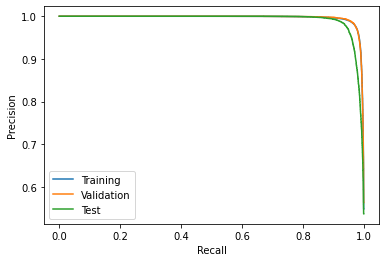

In [ ]:
# plot the precision-recall curves
pyplot.plot(t_recall, t_precision, label='Training')
pyplot.plot(v_recall, v_precision, label='Validation')
pyplot.plot(test_recall, test_precision, label='Test')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Model scores on the form reviews

In [ ]:
form_reviews_list = [
    "i love wetzels pretzels . my husband and i have been here several times and have never been disappointed . the food is always delicious and the service is always great . i have been here times and i have never had a bad experience .",
    "these empanadas are excellent we are argentinean so we will be back for sure . the food is great and the service is great . i have been here several times and i have never had a bad experience ",
    "great burgers , chicken sandwiches , salads , and breakfast items .  can enjoy the $6 dollar burger either with bun or low carb style .  one of my favorite burgers !",
    "great food ! had the rose sauce on pasta and it was delicious . the service was great and the food was delicious . i had the chicken and waffles and it was delicious .",
    "our hotel gave us vouchers for a free dinner . the food was delicious and the service was great . i will definitely be back to try more of their menu .",
    "always the best sushi everytime i come ! the food is always fresh and the service is great . the food is always good and the service is great . i love the atmosphere and the food is amazing .",
    "service was excellent , price was right and food was tasty . ignore these other comments .",
    "first time here and i was pleasantly surprised. i had the chicken and waffles with a side of bacon, and it was delicious. the service was great and the staff was very friendly. i would definitely recommend this place to anyone who loves the food and drink. i will definitely be back!",
    "definitely my favorite local pizza place . love their sweet sauce and the garlic dipping sauce . the portions are always huge. it's the biggest pizza i have seen . highly recommend .",
    "love this place! the food is amazing and the service is great. i would recommend this place to anyone who loves sushi.",
    "great food and great service. i had the chicken and waffles and it was amazing. i will definitely be back.",
    "delicious delicous declicous ! it is my go-to place for vietnemese food . i am never disappointed ! yummy soups and can never go wrong with the spring rolls .",
    "great food, great service, great atmosphere. i would definitely recommend this place to anyone who loves the food and service. ",
    "best pizza joint in the plum penn hills area ! get a pie with their sweet sauce . delicious !",
    "great food and great service!!! i was in town for a conference and we were so happy to see this place and we were so glad we found this place!!! the food was great, the service was great!!! i would definitely recommend this place to anyone!!!"
      

]

In [ ]:
cleaned_list = clean_text(form_reviews_list)

In [ ]:
tokens = tokenizer.texts_to_sequences(cleaned_list)
tokens = pad_sequences(tokens, maxlen= INPUT_LEN, padding='pre', truncating='post')
pred = classifier_model.predict_classes(tokens)

In [33]:
for i in range(15):
  print("Review: ",form_reviews_list[i])
  print("Classifier Prediction: ", pred[i])
  print()

Review:  i love wetzels pretzels . my husband and i have been here several times and have never been disappointed . the food is always delicious and the service is always great . i have been here times and i have never had a bad experience .
Classifier Prediction:  0

Review:  these empanadas are excellent we are argentinean so we will be back for sure . the food is great and the service is great . i have been here several times and i have never had a bad experience 
Classifier Prediction:  0

Review:  great burgers , chicken sandwiches , salads , and breakfast items .  can enjoy the $6 dollar burger either with bun or low carb style .  one of my favorite burgers !
Classifier Prediction:  1

Review:  great food ! had the rose sauce on pasta and it was delicious . the service was great and the food was delicious . i had the chicken and waffles and it was delicious .
Classifier Prediction:  0

Review:  our hotel gave us vouchers for a free dinner . the food was delicious and the service 